In [1]:
install.packages("TSA")
install.packages("forecast")
install.packages("lmtest")
install.packages("tsoutliers")
install.packages("expsmooth")
install.packages("fma")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘zoo’, ‘quantmod’, ‘leaps’, ‘locfit’, ‘tseries’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fracdiff’, ‘lmtest’, ‘Rcpp’, ‘timeDate’, ‘urca’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## 8.2 개입분석


### 예제 1. 
2001년 9월에 9/11테러로 인해 개입 발생


Attaching package: ‘TSA’


The following objects are masked from ‘package:stats’:

    acf, arima


The following object is masked from ‘package:utils’:

    tar




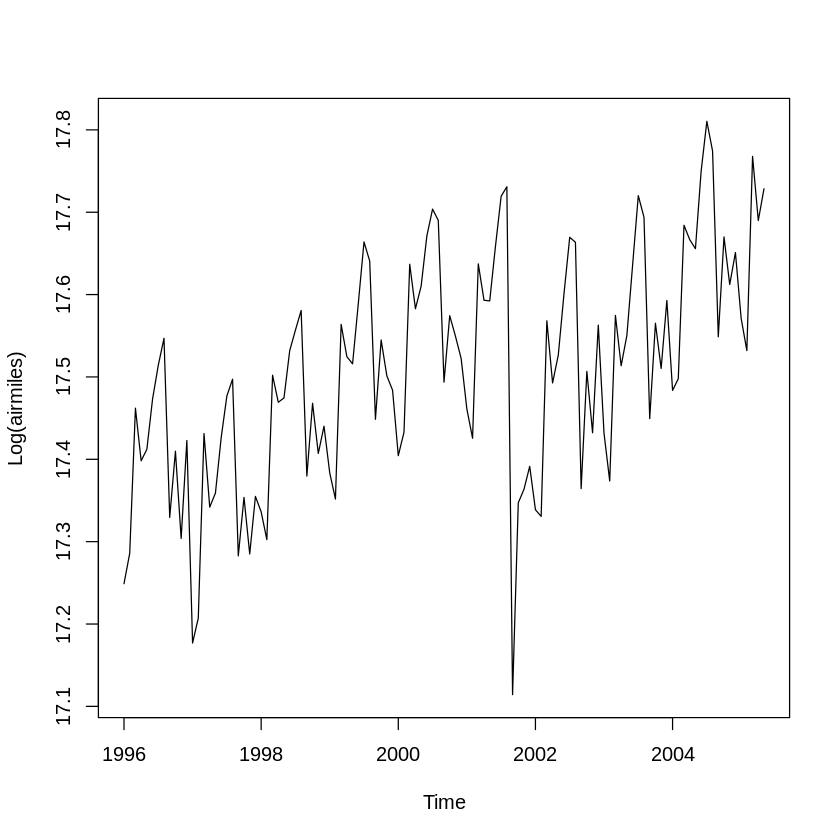

In [2]:
library(TSA)
data(airmiles)
plot(log(airmiles), ylab = "Log(airmiles)")

#### 개입 이전 자료 이용 : ARIMA 모형

In [3]:
library(forecast)
pre.model = auto.arima(window(log(airmiles), end = c(2001, 8)), trace = T)
future = length(window(airmiles, start = c(2001, 9)))
forecast = forecast(pre.model, future)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'forecast':
  method       from
  fitted.Arima TSA 
  plot.Arima   TSA 




 ARIMA(2,1,2)(1,1,1)[12]                    : -197.1535
 ARIMA(0,1,0)(0,1,0)[12]                    : -191.9266
 ARIMA(1,1,0)(1,1,0)[12]                    : -201.6306
 ARIMA(0,1,1)(0,1,1)[12]                    : -205.1655
 ARIMA(0,1,1)(0,1,0)[12]                    : -199.727
 ARIMA(0,1,1)(1,1,1)[12]                    : -202.8486
 ARIMA(0,1,1)(1,1,0)[12]                    : -203.9458
 ARIMA(0,1,0)(0,1,1)[12]                    : -193.8733
 ARIMA(1,1,1)(0,1,1)[12]                    : -203.4378
 ARIMA(0,1,2)(0,1,1)[12]                    : -203.7854
 ARIMA(1,1,0)(0,1,1)[12]                    : -203.0455
 ARIMA(1,1,2)(0,1,1)[12]                    : -201.5041

 Best model: ARIMA(0,1,1)(0,1,1)[12]                    



[1] -0.1086306

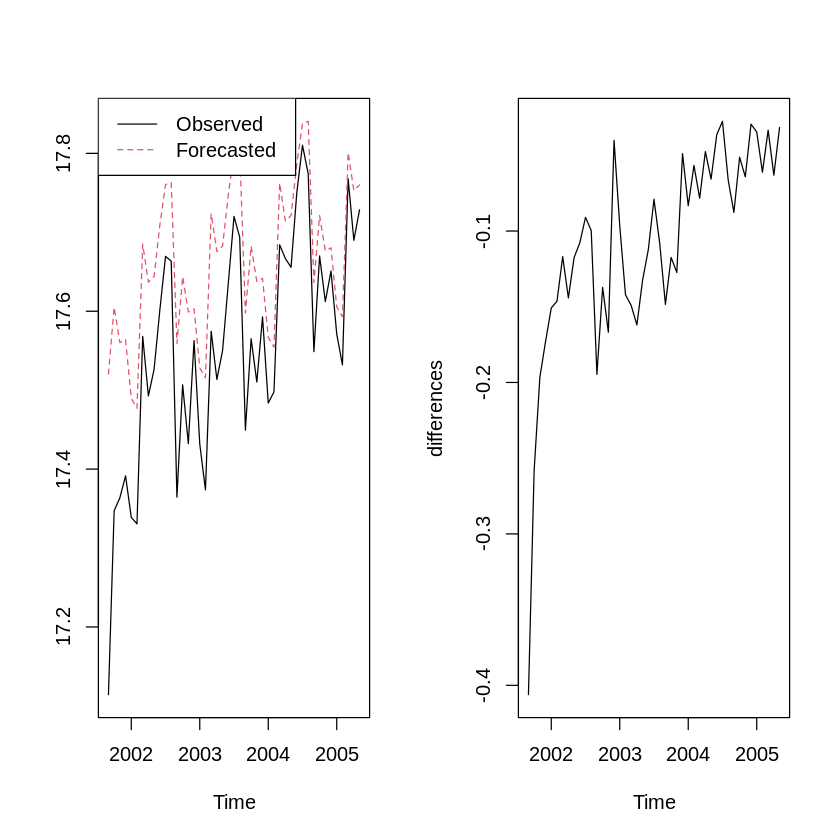

In [4]:
par(mfrow = c(1, 2))
ts.plot(window(log(airmiles), start = c(2001, 9)), forecast$mean, lty = 1:2, col = 1:2)
legend("topleft", c("Observed", "Forecasted"), lty = 1:2, col = 1:2)
diffs = log(airmiles) - forecast$mean
ts.plot(diffs, ylab = "differences")
mean(diffs)

+ 평균 -0.1086306만큼 과대추정이 이루어짐

In [5]:
int.model = arimax(log(airmiles), order = c(0, 1, 1), 
                   seasonal = list(order = c(0, 1, 1), period = 12),
                   xtransf = data.frame(I911 = 1 * (seq(airmiles) == 69),
                                        I911 = 1 * (seq(airmiles) == 69)),
                   transfer = list(c(0, 0), c(1, 0)), method = "ML")
summary(int.model)


Call:
arimax(x = log(airmiles), order = c(0, 1, 1), seasonal = list(order = c(0, 1, 
    1), period = 12), method = "ML", xtransf = data.frame(I911 = 1 * (seq(airmiles) == 
    69), I911 = 1 * (seq(airmiles) == 69)), transfer = list(c(0, 0), c(1, 0)))

Coefficients:
          ma1     sma1  I911-MA0  I911.1-AR1  I911.1-MA0
      -0.5379  -0.7644   -0.1290      0.8901     -0.2419
s.e.   0.0854   0.1532    0.0606      0.1239      0.0513

sigma^2 estimated as 0.0009739:  log likelihood = 199.42,  aic = -388.84

Training set error measures:
                      ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.002597811 0.02994997 0.01947992 0.01468367 0.1113954 0.2224128
                    ACF1
Training set -0.06351995

In [6]:
library(lmtest)
coeftest(int.model)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric





z test of coefficients:

            Estimate Std. Error z value  Pr(>|z|)    
ma1        -0.537855   0.085417 -6.2968 3.039e-10 ***
sma1       -0.764374   0.153237 -4.9882 6.096e-07 ***
I911-MA0   -0.128989   0.060630 -2.1275   0.03338 *  
I911.1-AR1  0.890105   0.123908  7.1836 6.792e-13 ***
I911.1-MA0 -0.241916   0.051329 -4.7131 2.440e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


+ 개입모형의 모든 효과가 통계적으로 유의함. 개입모형이 자료를 잘 적합하였음

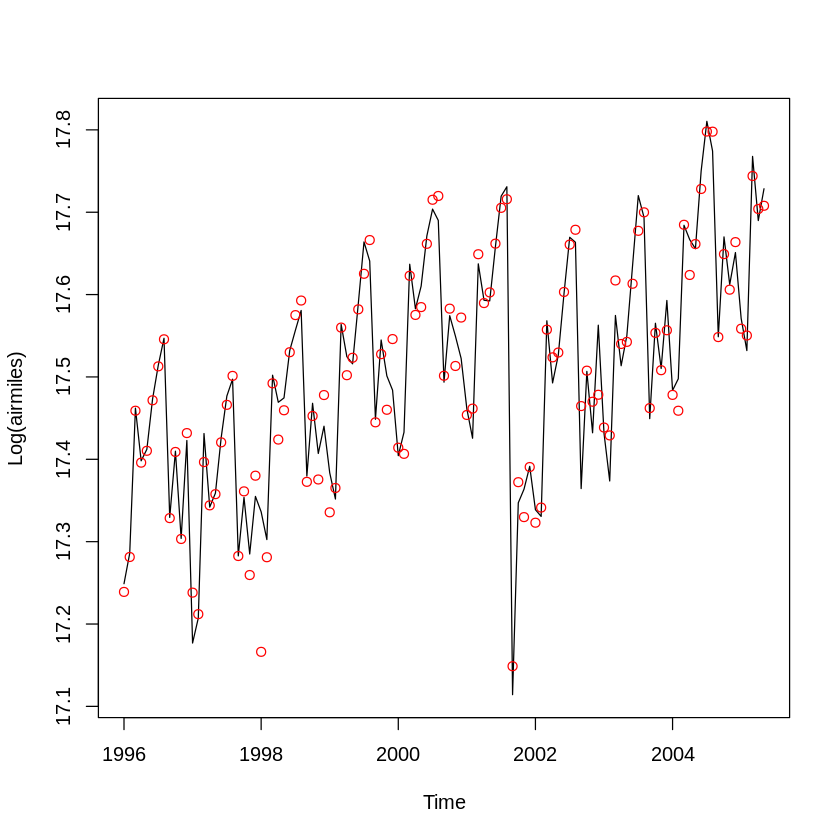

In [7]:
plot(log(airmiles), ylab = "Log(airmiles)")
points(fitted(int.model), col = "red")

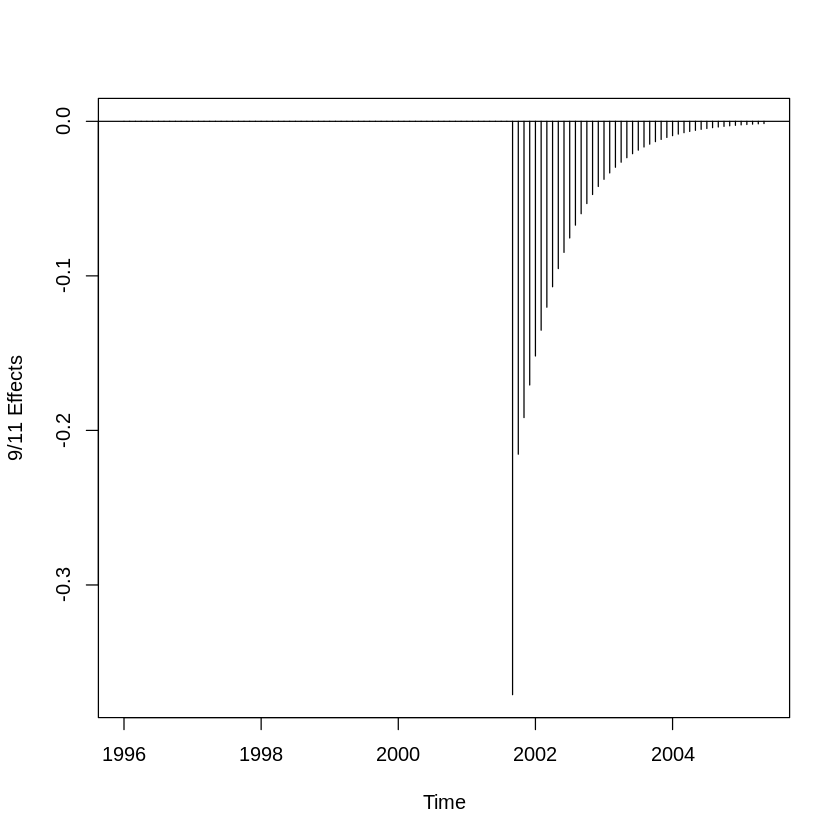

In [8]:
E911 = 1 * (seq(airmiles) == 69)
plot(ts(E911 * (-0.129) + filter(E911, filter = 0.890, method = "recursive") * (-0.242),
     frequency = 12, start = 1996), ylab = "9/11 Effects", type = "h")
abline(h = 0)

+ CCF가 time lag -1(-12), 0(0), 1(12)에서 유의하므로 mdeaths와 fdeaths 간에 동시차의 강한 양의 관계를 가짐을 알 수 있다

#### 전체 자료에 대해 ARIMA 모형 적합

In [9]:
arima = auto.arima(log(airmiles), trace = T)
summary(arima)


 ARIMA(2,0,2)(1,1,1)[12] with drift         : Inf
 ARIMA(0,0,0)(0,1,0)[12] with drift         : -201.5575
 ARIMA(1,0,0)(1,1,0)[12] with drift         : -274.3443
 ARIMA(0,0,1)(0,1,1)[12] with drift         : Inf
 ARIMA(0,0,0)(0,1,0)[12]                    : -190.4423
 ARIMA(1,0,0)(0,1,0)[12] with drift         : -264.1606
 ARIMA(1,0,0)(2,1,0)[12] with drift         : -278.3086
 ARIMA(1,0,0)(2,1,1)[12] with drift         : Inf
 ARIMA(1,0,0)(1,1,1)[12] with drift         : Inf
 ARIMA(0,0,0)(2,1,0)[12] with drift         : -209.1775
 ARIMA(2,0,0)(2,1,0)[12] with drift         : -282.0541
 ARIMA(2,0,0)(1,1,0)[12] with drift         : -279.1269
 ARIMA(2,0,0)(2,1,1)[12] with drift         : Inf
 ARIMA(2,0,0)(1,1,1)[12] with drift         : Inf
 ARIMA(3,0,0)(2,1,0)[12] with drift         : -281.734
 ARIMA(2,0,1)(2,1,0)[12] with drift         : -281.6817
 ARIMA(1,0,1)(2,1,0)[12] with drift         : -283.9627
 ARIMA(1,0,1)(1,1,0)[12] with drift         : -280.5374
 ARIMA(1,0,1)(2,1,1)[12] wit

Series: log(airmiles) 
ARIMA(1,0,1)(2,1,0)[12] 

Coefficients:
         ar1      ma1     sar1     sar2
      0.9392  -0.4254  -0.4690  -0.2223
s.e.  0.0410   0.1083   0.1006   0.0950

sigma^2 = 0.003204:  log likelihood = 147.37
AIC=-284.74   AICc=-284.11   BIC=-271.67

Training set error measures:
                      ME       RMSE        MAE       MPE      MAPE      MASE
Training set 0.008094132 0.05244721 0.02856046 0.0457115 0.1637807 0.3743434
                     ACF1
Training set -0.003616399

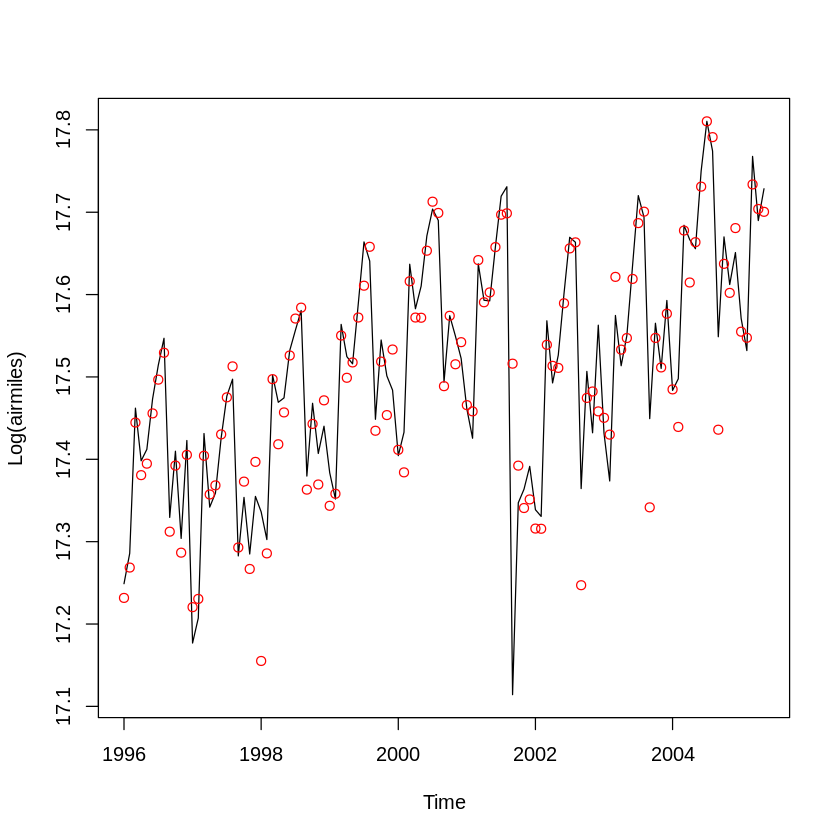

In [10]:
plot(log(airmiles), ylab = "Log(airmiles)")
points(fitted(arima), col = "red")

+ 전체 자료에 대한 ARIMA 모형의 성능이 개입모형에 비해 떨어진다.

## 8.3 이상점 탐지

### 참고 : 이상점의 종류에 따른 형태 시각화

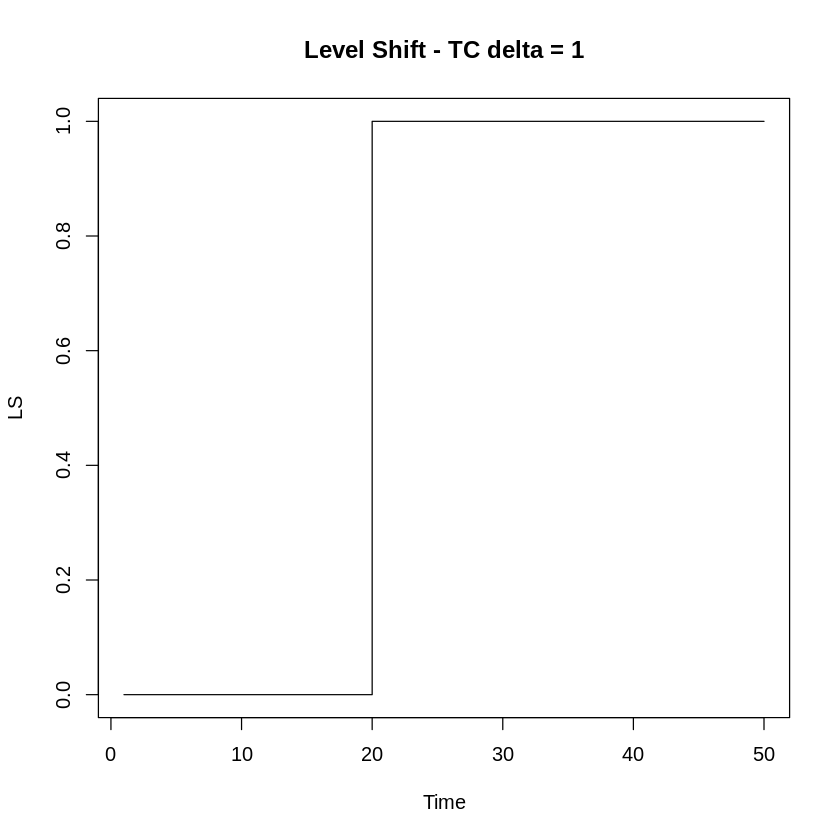

In [11]:
ts = ts(rep(0, 50))
ts[20] = 1

LS = filter(ts, filter = 1, method = "recursive")
plot(LS, main = "Level Shift - TC delta = 1", type = "s")

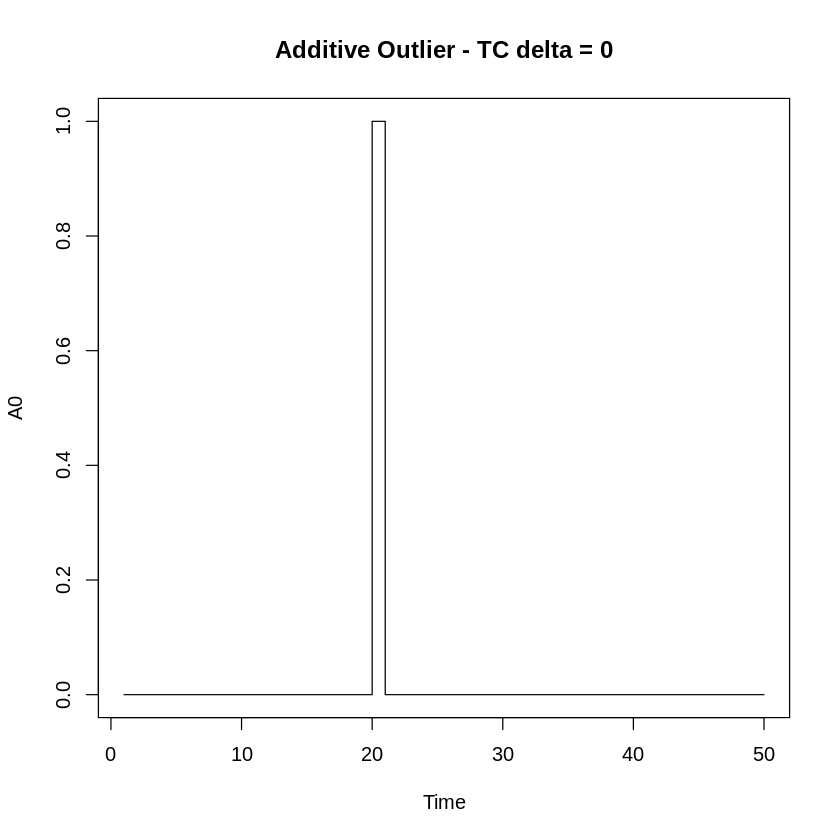

In [12]:
A0 = filter(ts, filter = 0, method = "recursive")
plot(A0, main = "Additive Outlier - TC delta = 0", type = "s")

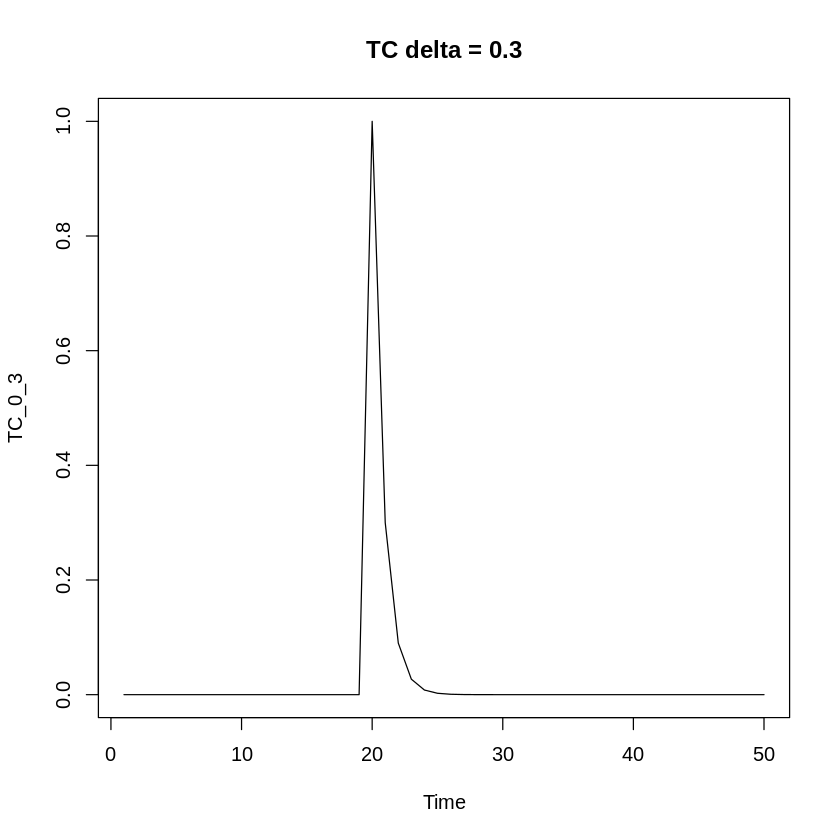

In [13]:
TC_0_3 = filter(ts, filter = 0.3, method = "recursive")
plot(TC_0_3, main = "TC delta = 0.3")

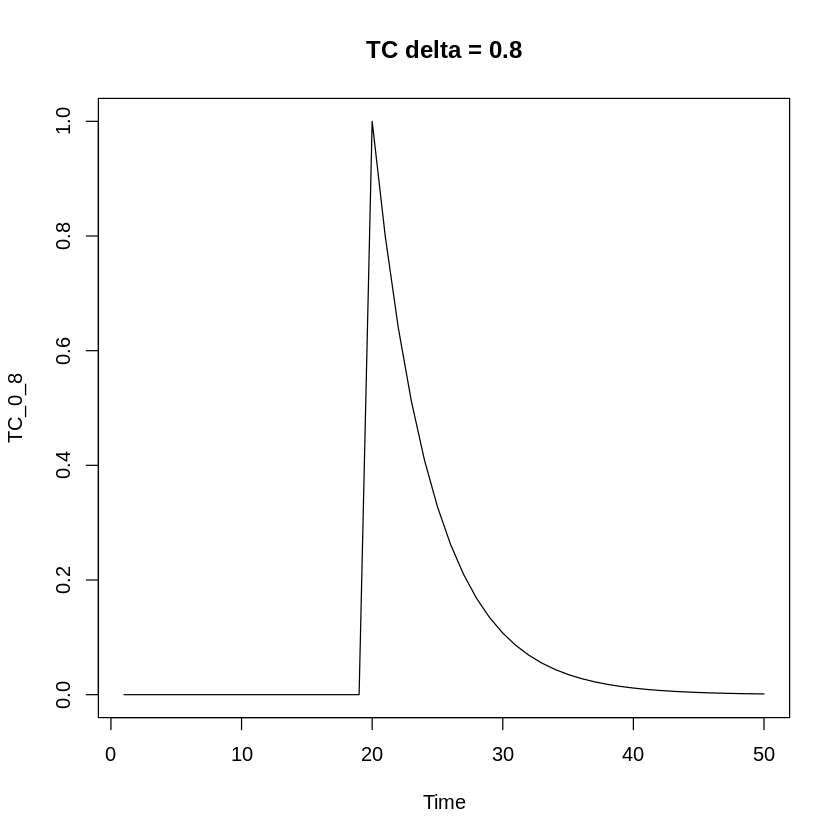

In [14]:
TC_0_8 = filter(ts, filter = 0.8, method = "recursive")
plot(TC_0_8, main = "TC delta = 0.8")

### 예제 2
9/11 개입의 시점을 모른다고 가정하고 진행해보자.

Warning message in locate.outliers.iloop(resid = resid, pars = pars, cval = cval, :
“stopped when ‘maxit.iloop’ was reached”
Warning message in locate.outliers.iloop(resid = resid, pars = pars, cval = cval, :
“stopped when ‘maxit.iloop’ was reached”
Warning message in locate.outliers.iloop(resid = resid, pars = pars, cval = cval, :
“stopped when ‘maxit.iloop’ was reached”


Series: log(airmiles) 
Regression with ARIMA(1,1,1)(0,0,2)[12] errors 

Coefficients:
         ar1      ma1    sma1    sma2     SLS9     TC69
      0.6277  -0.9390  1.0223  0.5111  -0.1639  -0.3380
s.e.  0.1139   0.0558  0.1171  0.0953   0.0312   0.0318

sigma^2 = 0.002446:  log likelihood = 173.71
AIC=-333.42   AICc=-332.34   BIC=-314.39

Outliers:
  type ind    time coefhat   tstat
1  SLS   9 1996:09 -0.1639  -5.256
2   TC  69 2001:09 -0.3380 -10.628

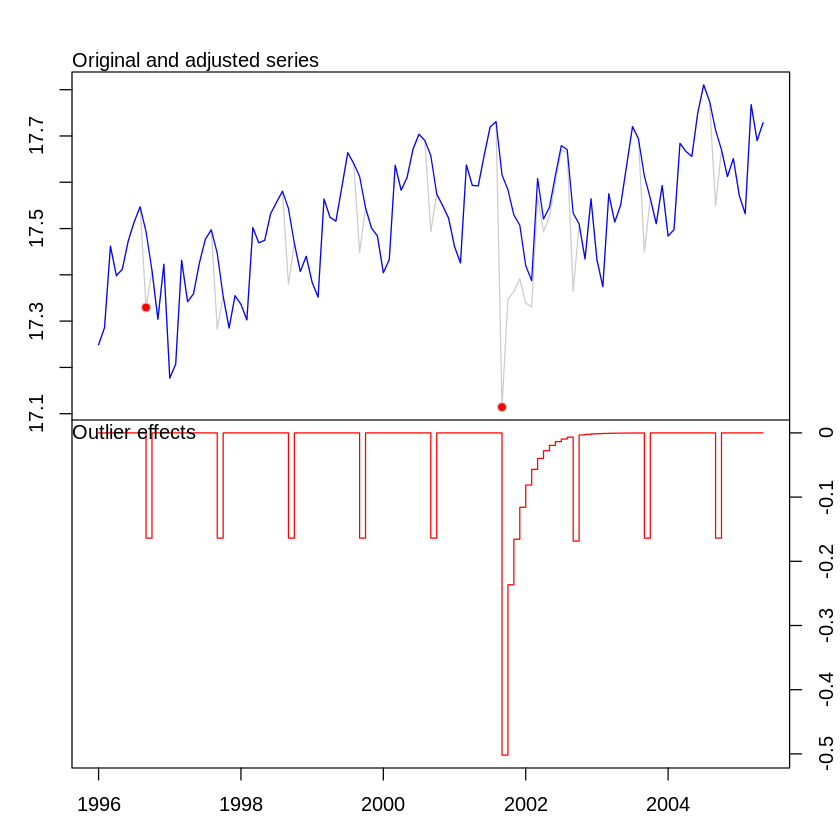

In [15]:
library(tsoutliers)
out = tso(log(airmiles), type = c("TC", "A0", "LS", "IO", "SLS"))
out
plot(out)

In [16]:
out$outliers

type,ind,time,coefhat,tstat
<fct>,<int>,<chr>,<dbl>,<dbl>
SLS,9,1996:09,-0.1638913,-5.255549
TC,69,2001:09,-0.3379978,-10.628228


In [17]:
# TC 효과 변수 지정
out_TC = out$outliers[2,]
out_TC

,type,ind,time,coefhat,tstat
,<fct>,<int>,<chr>,<dbl>,<dbl>
2,TC,69,2001:09,-0.3379978,-10.62823


In [18]:
# 탐지된 이상점의 시간 색인
out_id = out_TC$ind
out_id

[1] 69

In [19]:
# 탐지된 이상점의 달력 년
out_TC$time

[1] "2001:09"

In [20]:
# 시계열의 길이
n = length(airmiles)
n

[1] 113

In [21]:
# 시계열에서 발견된 동일한 시간 색인에서 TC 이상치
out_df = outliers("TC", out_id)
out_df

type,ind,coefhat
<fct>,<int>,<dbl>
TC,69,1


In [22]:
# TC의 효과가 저장된 1열 구조의 행렬
TC = outliers.effects(out_df, n)
tail(TC)

,TC69
"[108,]",9.095437e-07
"[109,]",6.366806e-07
"[110,]",4.456764e-07
"[111,]",3.119735e-07
"[112,]",2.183814e-07
"[113,]",1.528670e-07


In [23]:
# 수치로 변환
coefhat = as.numeric(out_TC$coefhat)
coefhat

[1] -0.3379978

In [24]:
# TC 효과
TC_eff = coefhat * TC
tail(TC_eff)

,TC69
"[108,]",-3.074238e-07
"[109,]",-2.151966e-07
"[110,]",-1.506376e-07
"[111,]",-1.054464e-07
"[112,]",-7.381245e-08
"[113,]",-5.166871e-08


In [25]:
# TC 효과 자료의 시계열
TC_effect = ts(TC_eff, frequency = frequency(airmiles), start = start(airmiles))
tail(TC_effect)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2004,,,,,,,,,,,,-3.074238e-07
2005,-2.151966e-07,-1.506376e-07,-1.054464e-07,-7.381245e-08,-5.166871e-08,,,,,,,


In [26]:
# TC 효과 제거 계열 = (원 계열 - TC 효과 계열)
diffs = log(airmiles) - TC_effect
diffs

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1996,17.24895,17.28585,17.46208,17.39817,17.41212,17.47322,17.51423,17.54693,17.32946,17.40980,17.30395,17.42280
1997,17.17692,17.20717,17.43127,17.34193,17.35894,17.42594,17.47683,17.49726,17.28273,17.35373,17.28503,17.35494
1998,17.33625,17.30253,17.50209,17.46924,17.47454,17.53199,17.55682,17.58069,17.37965,17.46800,17.40710,17.44017
1999,17.38365,17.35176,17.56379,17.52464,17.51592,17.58890,17.66393,17.64069,17.44859,17.54484,17.50128,17.48394
2000,17.40444,17.43289,17.63683,17.58281,17.61027,17.67121,17.70378,17.69005,17.49368,17.57440,17.54954,17.52241
2001,17.46113,17.42560,17.63730,17.59313,17.59228,17.65827,17.71945,17.73093,17.45223,17.58380,17.52930,17.50735
2002,17.41995,17.38747,17.60792,17.52057,17.54600,17.61470,17.67910,17.67020,17.36914,17.50999,17.43449,17.56443
2003,17.43288,17.37448,17.57518,17.51399,17.55047,17.63544,17.72031,17.69394,17.44944,17.56523,17.51036,17.59285
2004,17.48370,17.49779,17.68413,17.66674,17.65570,17.74996,17.81036,17.77428,17.54881,17.67003,17.61221,17.65101
2005,17.57113,17.53203,17.76777,17.68989,17.72849,,,,,,,


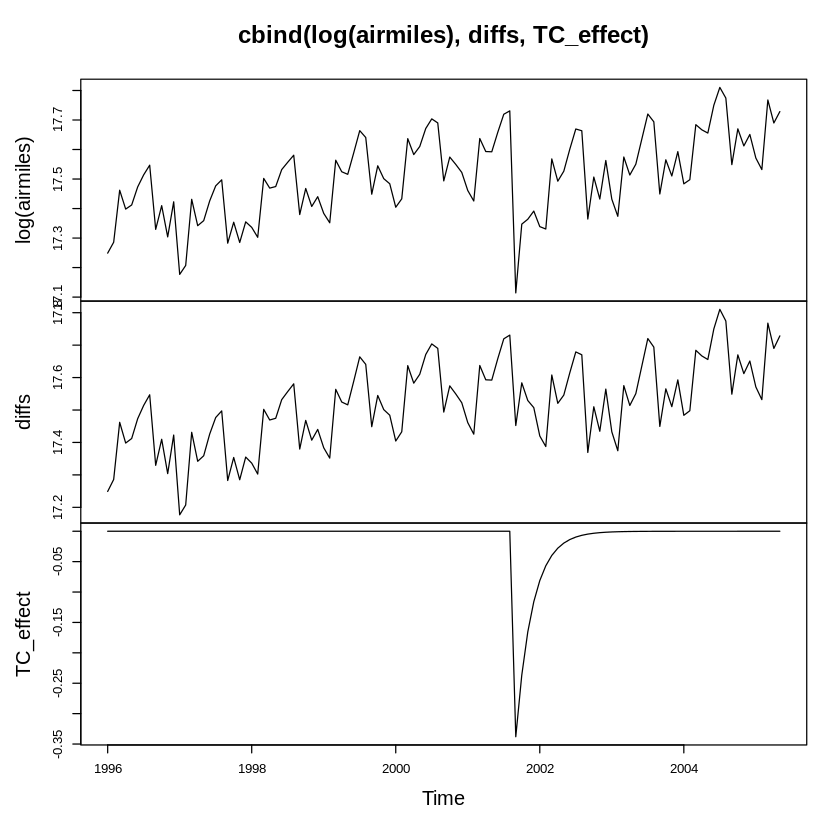

In [27]:
# 원 계열, 차이 계열, TC 효과 계열 그림
plot(cbind(log(airmiles), diffs, TC_effect)) 

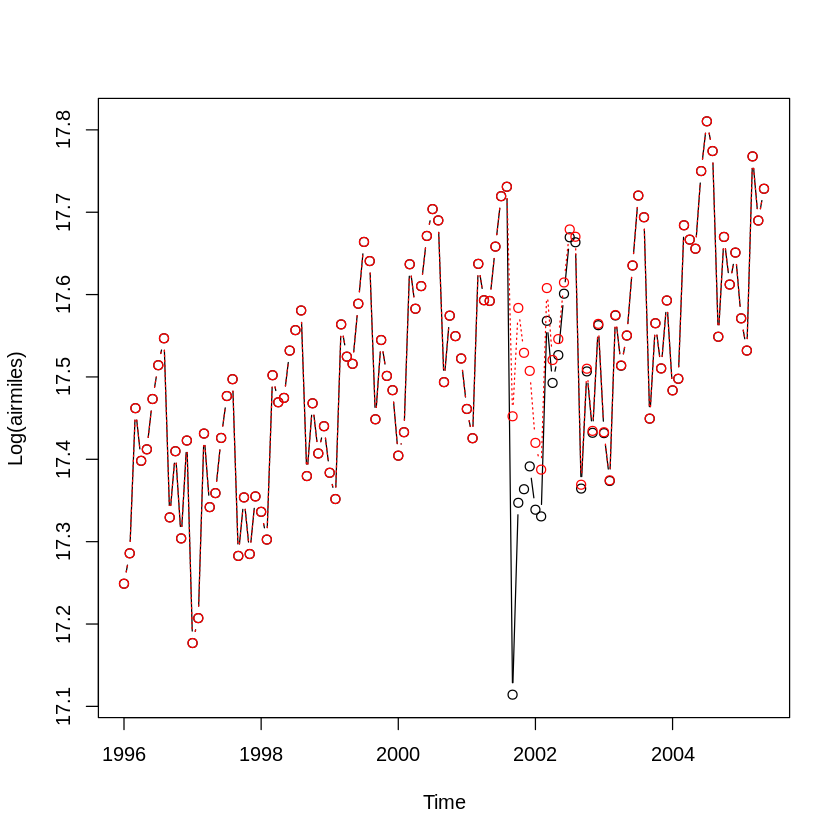

In [28]:
# 원 계열과 TC 효과 제거 계열의 시각화
plot(log(airmiles), type = "b", ylab = "Log(airmiles)")
lines(diffs, col = "red", lty = 3, type = "b")

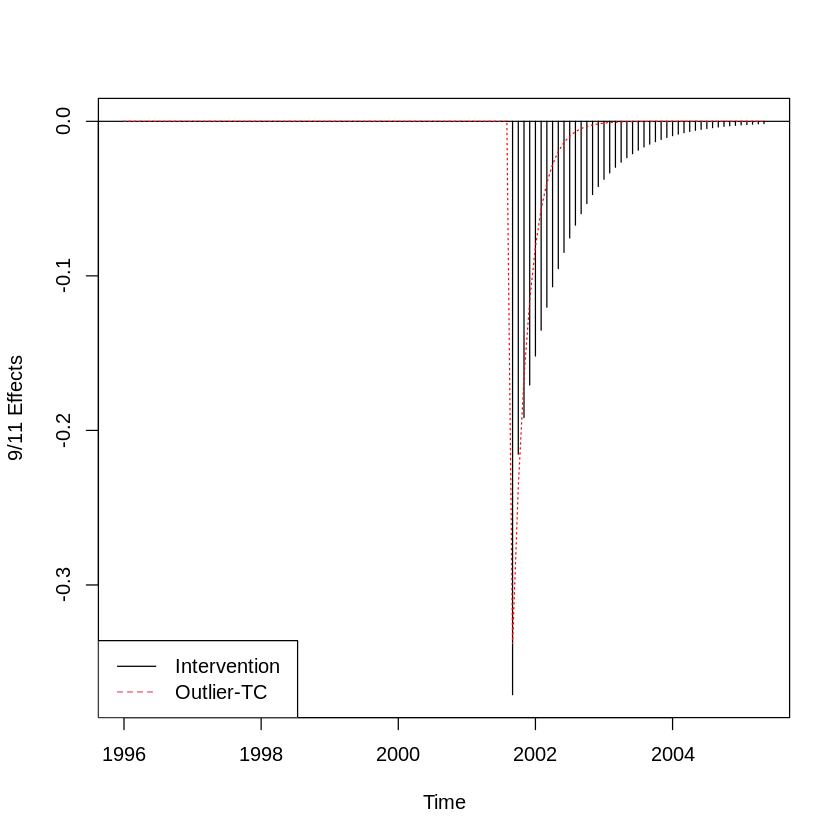

In [29]:
# [예제 1]의 개입 효과와 TC 효과와의 비교
E911 = 1 * (seq(airmiles) == 69)
plot(ts(E911 * (-0.129) + filter(E911, filter = 0.890, method = "recursive", side = 1) * (-0.242),
     frequency = 12, start = 1996), ylab = "9/11 Effects", type = "h")
abline(h = 0)
lines(TC_effect, col = "red", lty = 3)
legend("bottomleft", c("Intervention", "Outlier-TC"), lty = 1:2, col = 1:2)

+ TC효과가 [예제 1]의 개입효과보다 빠르게 감소하는 형태를 보임

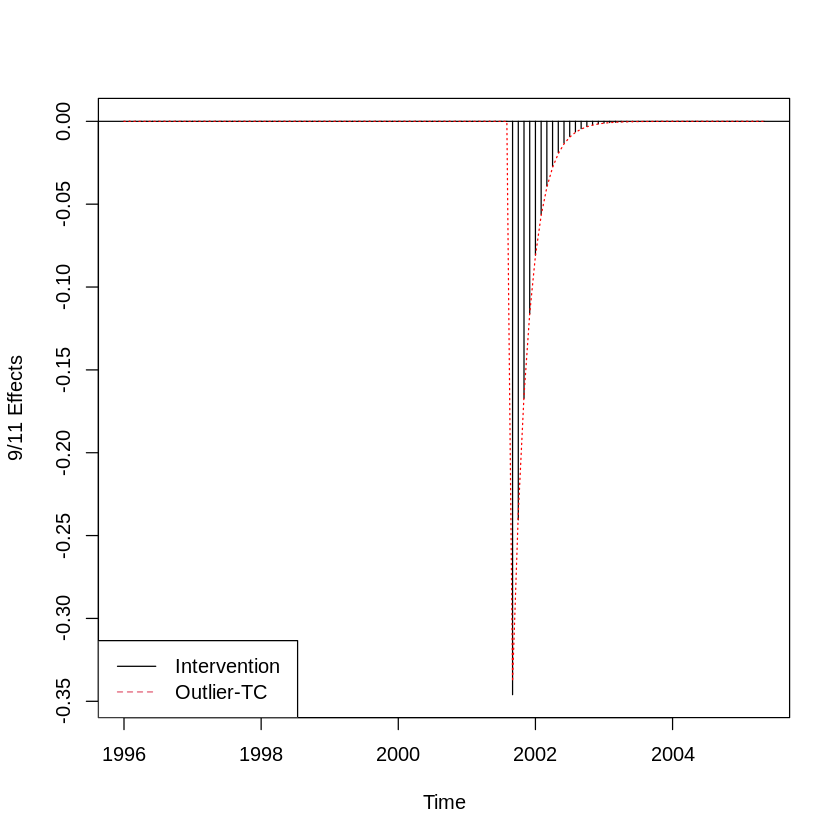

In [30]:
# [예제 1]의 개입 효과(입력변수로 두 번째 항만 이용하여 적합)와 TC 효과와의 비교
E911 = 1 * (seq(airmiles) == 69)
plot(ts(filter(E911, filter = 0.695, method = "recursive", side = 1) * (-0.346),
     frequency = 12, start = 1996), ylab = "9/11 Effects", type = "h")
abline(h = 0)
lines(TC_effect, col = "red", lty = 3)
legend("bottomleft", c("Intervention", "Outlier-TC"), lty = 1:2, col = 1:2)

+ [예제 1]의 변형모형에 대한 개입효과와 TC 효과가 매우 유사함

### 예제 3

Series: chicken 
Regression with ARIMA(0,1,0) errors 

Coefficients:
         LS12     TC20
      37.1400  36.3763
s.e.  11.7778  10.8586

sigma^2 = 142.9:  log likelihood = -268.08
AIC=542.15   AICc=542.52   BIC=548.85

Outliers:
  type ind time coefhat tstat
1   LS  12 1935   37.14 3.153
2   TC  20 1943   36.38 3.350

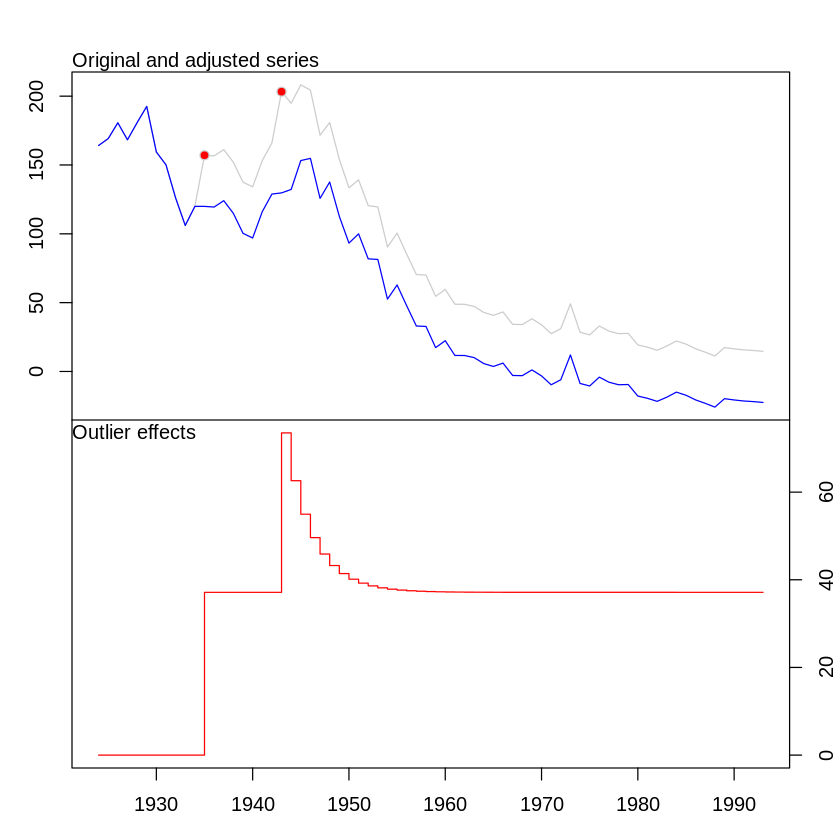

In [31]:
library(tsoutliers)
library(expsmooth)
library(fma)
outlier = tsoutliers::tso(chicken, types = c("A0", "LS", "TC"), maxit.iloop = 10)
outlier
plot(outlier)

In [32]:
n = length(chicken)
n

[1] 70

In [33]:
LS.df = outliers("LS", 12)
LS.df

type,ind,coefhat
<fct>,<dbl>,<dbl>
LS,12,1


In [34]:
LS_effect = outliers.effects(LS.df, n)
tail(LS_effect)

,LS12
"[65,]",1
"[66,]",1
"[67,]",1
"[68,]",1
"[69,]",1
"[70,]",1


In [35]:
TC.df = outliers("TC", 20)
TC.df

type,ind,coefhat
<fct>,<dbl>,<dbl>
TC,20,1


In [36]:
TC_effect = outliers.effects(TC.df, n)
tail(TC_effect)

,TC20
"[65,]",1.070069e-07
"[66,]",7.490483e-08
"[67,]",5.243338e-08
"[68,]",3.670337e-08
"[69,]",2.569236e-08
"[70,]",1.798465e-08


In [37]:
xreg.outliers = cbind(LS_effect, TC_effect)
tail(xreg.outliers)

,LS12,TC20
"[65,]",1,1.070069e-07
"[66,]",1,7.490483e-08
"[67,]",1,5.243338e-08
"[68,]",1,3.670337e-08
"[69,]",1,2.569236e-08
"[70,]",1,1.798465e-08


In [38]:
arima.model = auto.arima(chicken, xreg = xreg.outliers)
arima.model

Series: chicken 
Regression with ARIMA(0,1,0) errors 

Coefficients:
        drift     LS12     TC20
      -2.7450  39.8850  36.3763
s.e.   1.3895  11.5422  10.5640

sigma^2 = 137.3:  log likelihood = -266.18
AIC=540.36   AICc=540.98   BIC=549.29